In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 


In [2]:
import os

output_dir = '/kaggle/input/kermany2018/OCT2017 /train'

class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)

    if os.path.exists(class_dir):
        num_images = len(os.listdir(class_dir))
        print(f"{class_name}: {num_images} images")
    else:
        print(f"Directory not found: {class_dir}")


CNV: 37205 images
DME: 11348 images
DRUSEN: 8616 images
NORMAL: 26315 images


Categories: ['DRUSEN', 'CNV', 'NORMAL', 'DME']


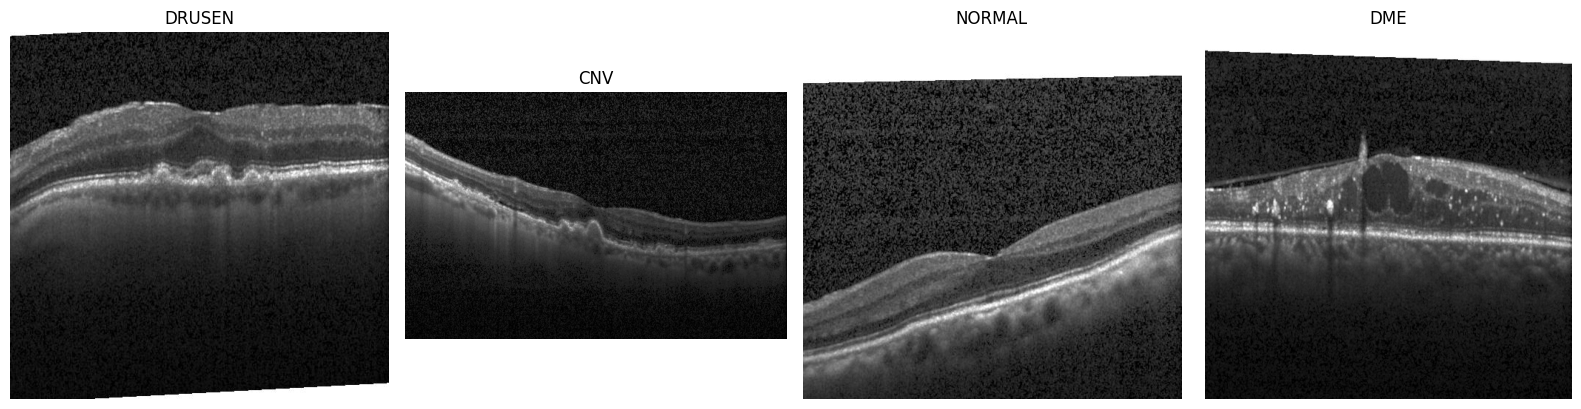

In [3]:
from PIL import Image
train_dir="/kaggle/input/kermany2018/OCT2017 /train"
categories = os.listdir(train_dir)
print("Categories:", categories)

num_categories = len(categories)

plt.figure(figsize=(num_categories * 4, 4))

for idx, category in enumerate(categories):
    category_path = os.path.join(train_dir, category)
    image_files = os.listdir(category_path)

    if image_files:
        img_path = os.path.join(category_path, image_files[0])
        img = Image.open(img_path)

        # Subplot لكل فئة
        plt.subplot(1, num_categories, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(category)
        plt.axis('off')

plt.tight_layout()
plt.show()


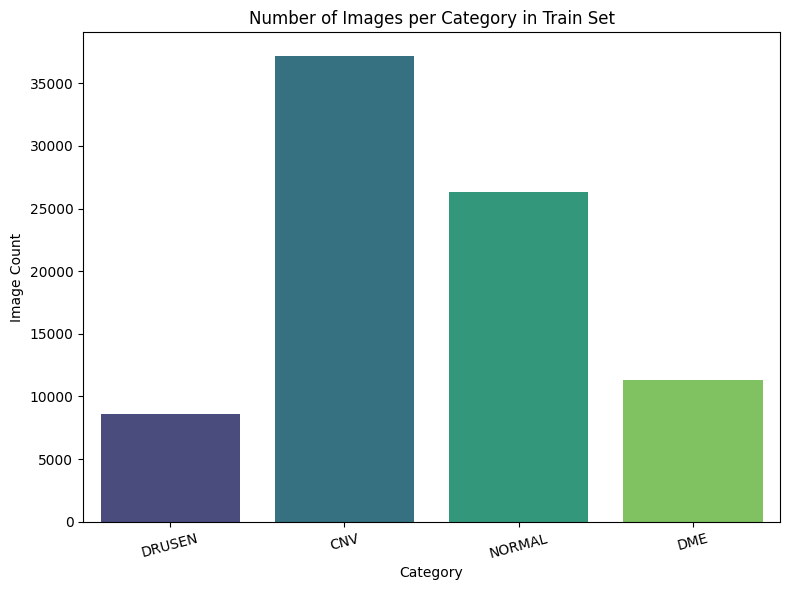

In [4]:
import seaborn as sns
category_counts = {}
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    count = len(os.listdir(category_path))
    category_counts[category] = count

df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data=df, palette='viridis')

plt.title('Number of Images per Category in Train Set')
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


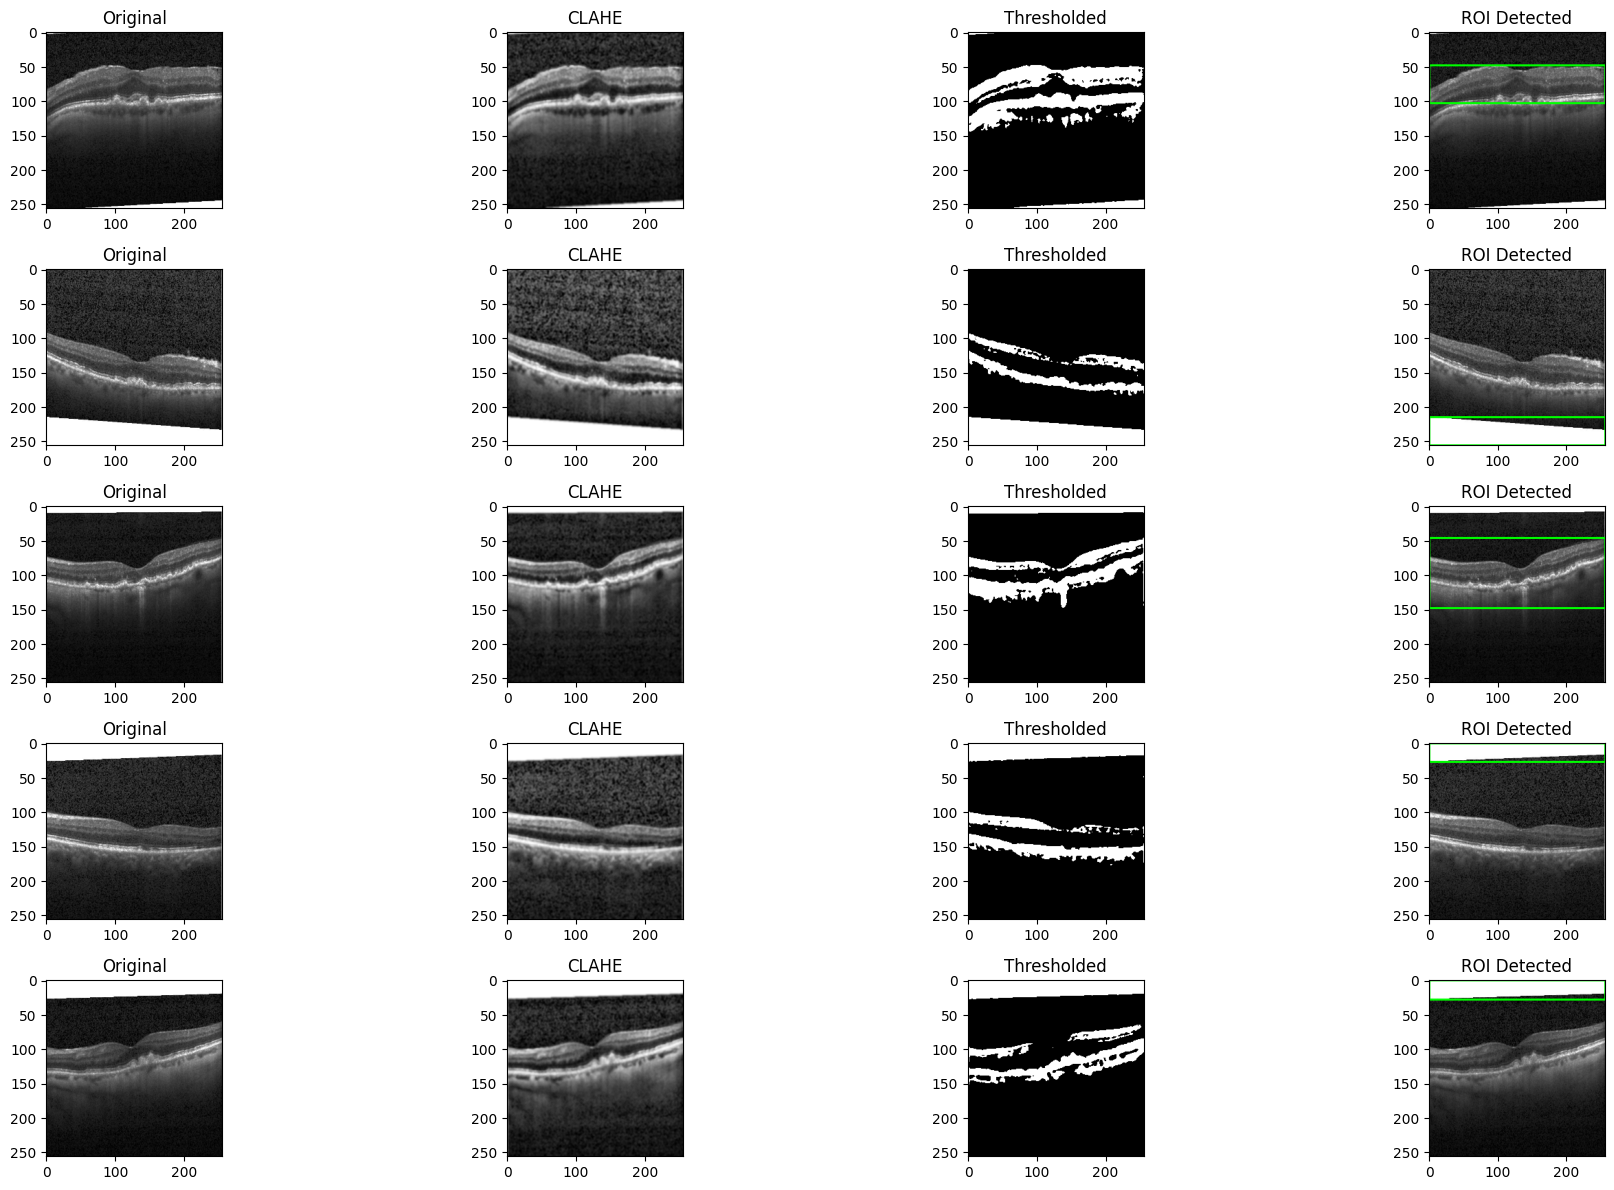

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm

# مسار كل الصور داخل combined_dataset (تشمل كل التصنيفات)
all_image_paths = glob('/kaggle/input/kermany2018/OCT2017 /train/*/*.jpeg')  

# دالة لتنفيذ خطوات الـ preprocessing + ROI detection
def process_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (256, 256))
    img_blur = cv2.GaussianBlur(img_resized, (5, 5), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_blur)
    _, img_thresh = cv2.threshold(img_clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_contour = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)

    if contours:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(img_contour, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return img_resized, img_clahe, img_thresh, img_contour

# خدي أول 5 صور فقط للعرض
sample_imgs = all_image_paths[:5]

# عرض النتائج
plt.figure(figsize=(20, 12))
for idx, path in enumerate(sample_imgs):
    img_resized, img_clahe, img_thresh, img_contour = process_image(path)

    plt.subplot(len(sample_imgs), 4, idx * 4 + 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title('Original')

    plt.subplot(len(sample_imgs), 4, idx * 4 + 2)
    plt.imshow(img_clahe, cmap='gray')
    plt.title('CLAHE')

    plt.subplot(len(sample_imgs), 4, idx * 4 + 3)
    plt.imshow(img_thresh, cmap='gray')
    plt.title('Thresholded')

    plt.subplot(len(sample_imgs), 4, idx * 4 + 4)
    plt.imshow(img_contour)
    plt.title('ROI Detected')

plt.tight_layout()
plt.show()


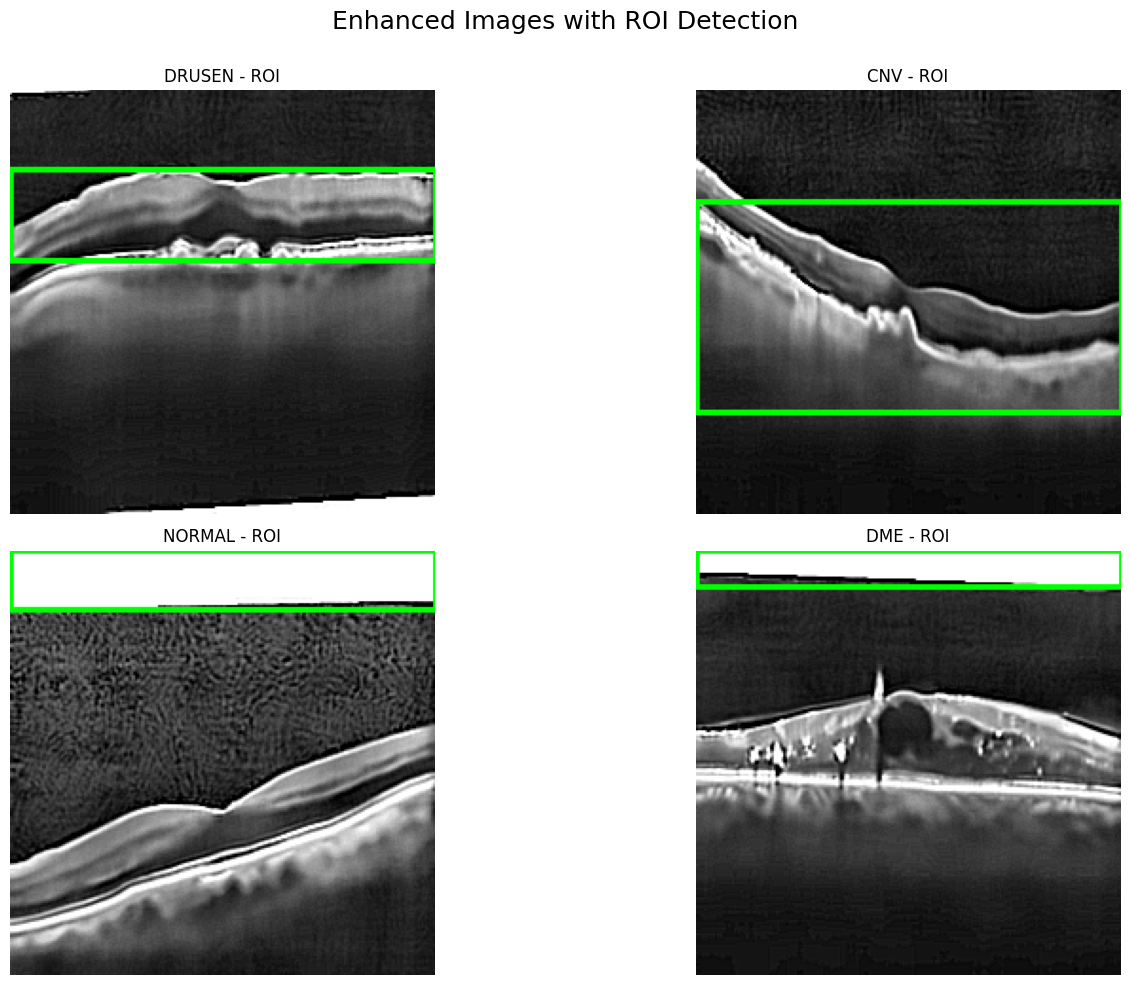

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

balanced_dir = "/kaggle/input/kermany2018/OCT2017 /train"

categories = [cat for cat in os.listdir(balanced_dir) if os.path.isdir(os.path.join(balanced_dir, cat))]
num_categories_to_show = min(4, len(categories))

plt.figure(figsize=(16, 10))

for i, category in enumerate(categories[:num_categories_to_show]):
    category_path = os.path.join(balanced_dir, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"No images found in {category_path}. Skipping.")
        continue

    img_path = os.path.join(category_path, image_files[0])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Failed to load image: {img_path}. Skipping.")
        continue

    # Step 1: Resize
    img_resized = cv2.resize(img, (224, 224))

    # Step 2: Denoise
    img_denoised = cv2.fastNlMeansDenoising(img_resized, h=15)

    # Step 3: CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))
    img_clahe = clahe.apply(img_denoised)

    # Step 4: Blur + Sharpen
    img_blur = cv2.GaussianBlur(img_clahe, (3, 3), 0)
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    img_sharpened = cv2.filter2D(img_blur, -1, sharpen_kernel)

    # Step 5: ROI Detection using Threshold + Contours
    _, img_thresh = cv2.threshold(img_sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_roi = cv2.cvtColor(img_sharpened, cv2.COLOR_GRAY2BGR)
    if contours:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(img_roi, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Step 6: Plot with ROI box
    plt.subplot(2, 2, i + 1)
    plt.imshow(img_roi)
    plt.title(f"{category} - ROI")
    plt.axis('off')

plt.suptitle("Enhanced Images with ROI Detection", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [7]:
import os
import random
import shutil
train_dir="/kaggle/input/kermany2018/OCT2017 /train"
balanced_dir = '/kaggle/working/train_balanced'
os.makedirs(balanced_dir, exist_ok=True)

min_count = min([len(os.listdir(os.path.join(train_dir, cat))) for cat in os.listdir(train_dir)])
print("Balancing to:", min_count, "images per category")

for category in os.listdir(train_dir):
    src_path = os.path.join(train_dir, category)
    dst_path = os.path.join(balanced_dir, category)
    os.makedirs(dst_path, exist_ok=True)

    images = os.listdir(src_path)
    sampled_images = random.sample(images, min_count)

    for img_name in sampled_images:
        shutil.copy(os.path.join(src_path, img_name), os.path.join(dst_path, img_name))


Balancing to: 8616 images per category


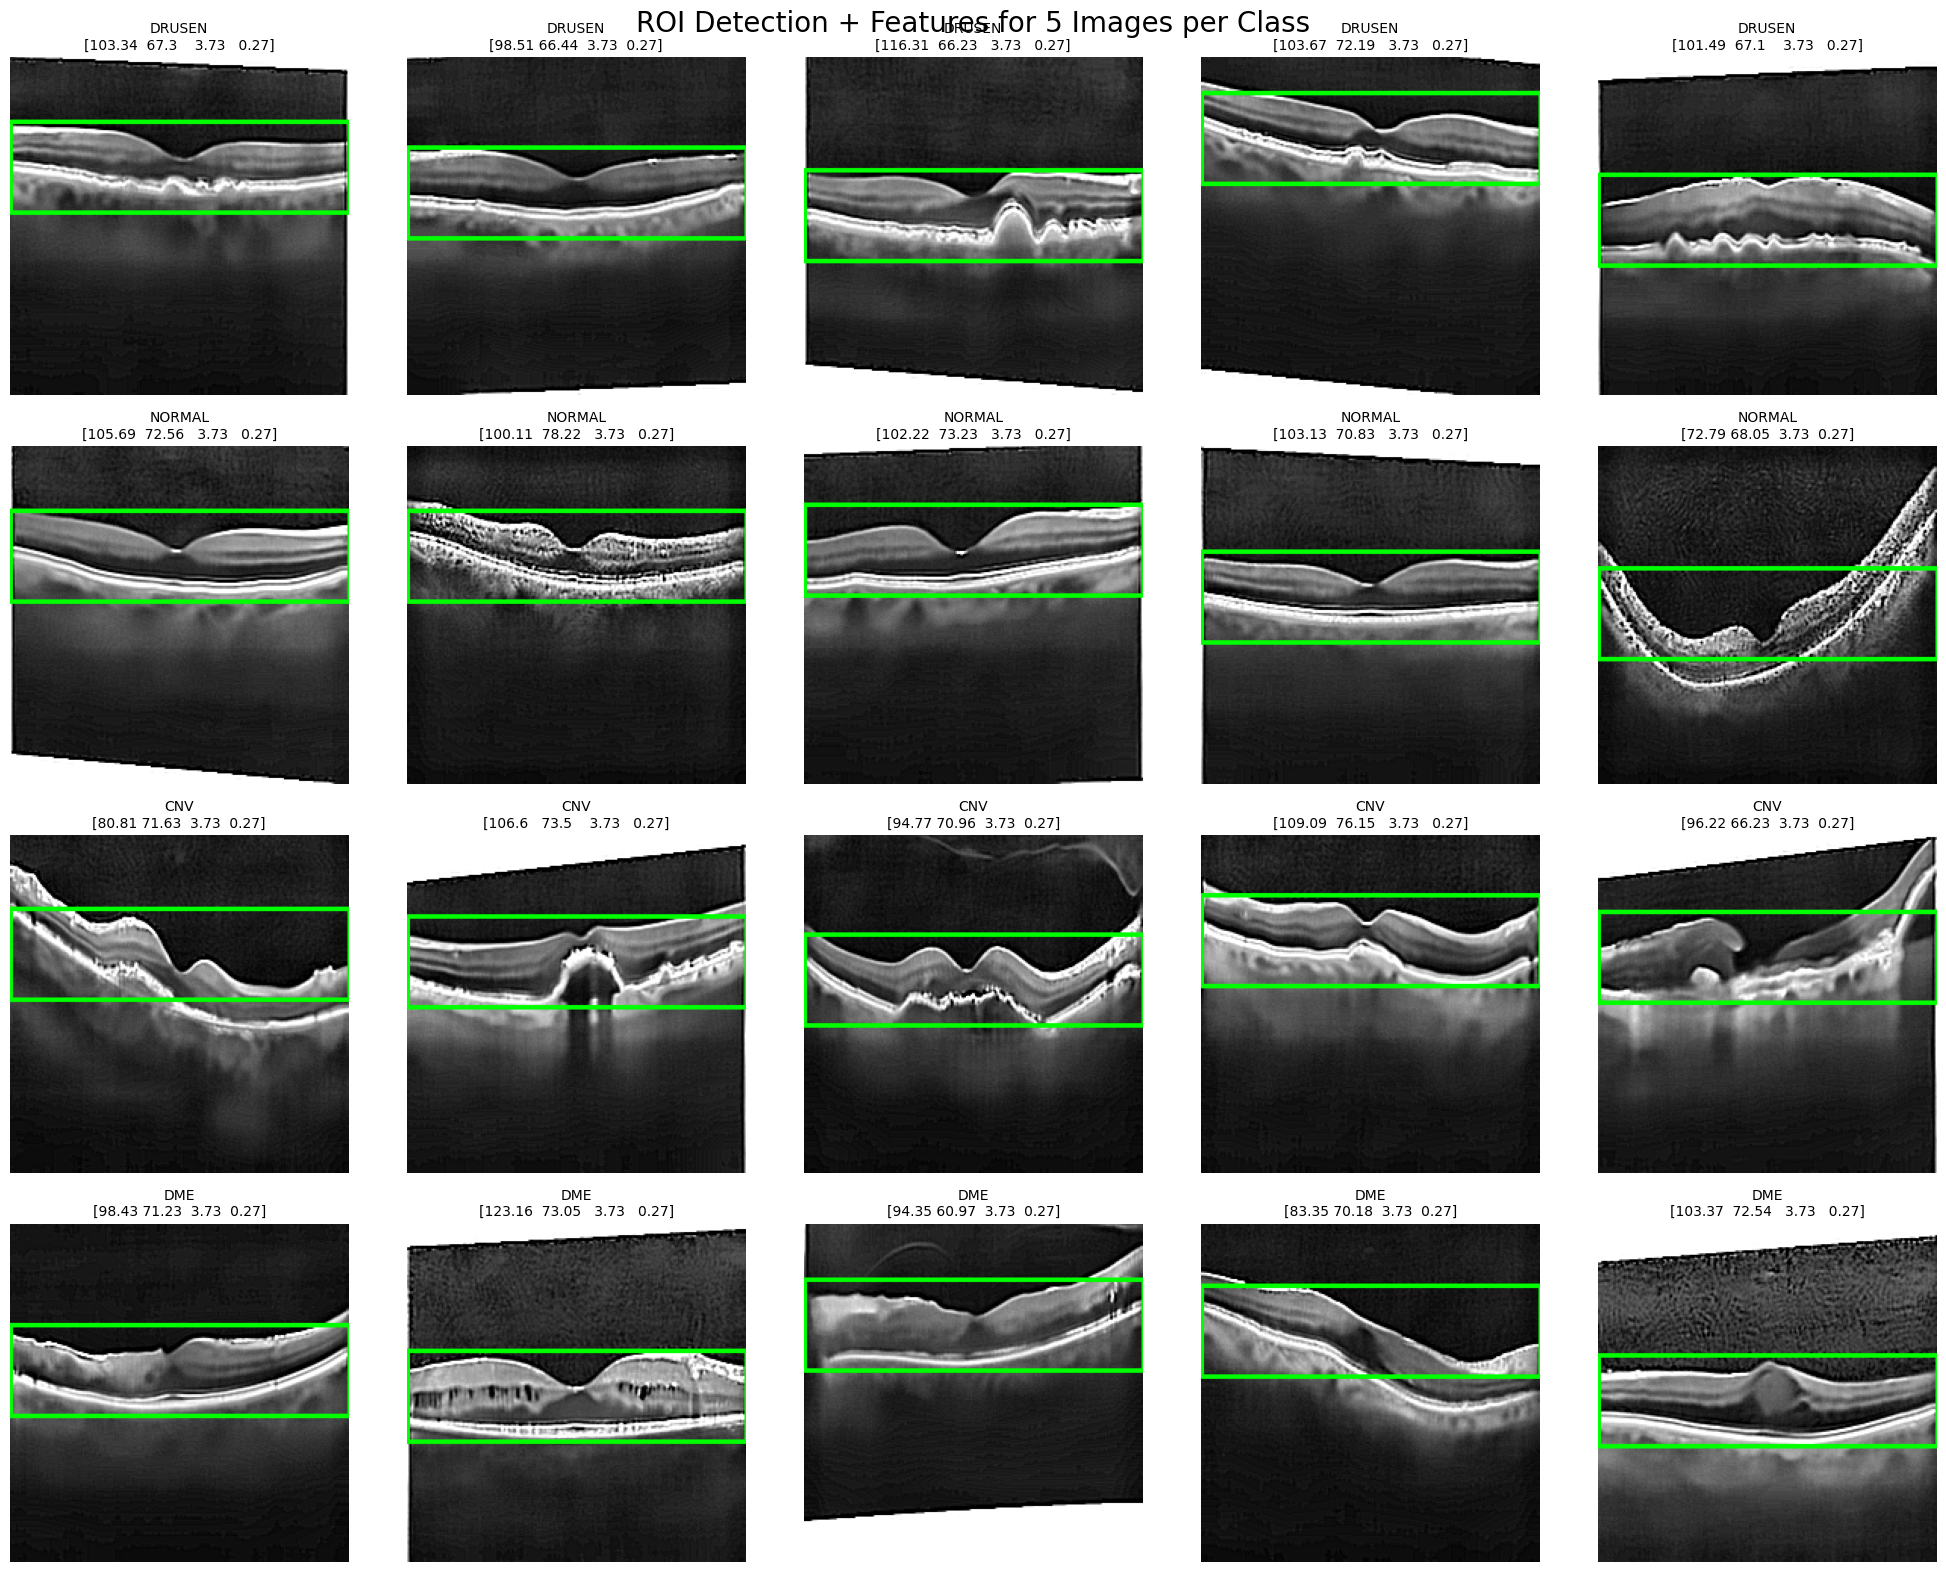

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def preprocess_image(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.fastNlMeansDenoising(img, h=15)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))
    img = clahe.apply(img)

    blur = cv2.GaussianBlur(img, (3, 3), 0)
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    img = cv2.filter2D(blur, -1, sharpen_kernel)
    return img

def detect_roi_by_edge_density(img_gray):
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    row_sum = np.sum(magnitude, axis=1)

    window_height = 60
    max_density = 0
    best_top = 0
    for top in range(0, len(row_sum) - window_height):
        density = np.sum(row_sum[top:top + window_height])
        if density > max_density:
            max_density = density
            best_top = top

    roi_box = (0, best_top, img_gray.shape[1], window_height)
    return roi_box

def extract_features(img, roi_box):
    x, y, w, h = roi_box
    roi = img[y:y+h, x:x+w]
    mean_val = np.mean(roi)
    std_val = np.std(roi)
    aspect_ratio = w / h
    area_ratio = (w * h) / (img.shape[0] * img.shape[1])
    return [mean_val, std_val, aspect_ratio, area_ratio]

# ----------- Dataset Path ----------- #
balanced_dir = "/kaggle/working/train_balanced"
categories = [cat for cat in os.listdir(balanced_dir) if os.path.isdir(os.path.join(balanced_dir, cat))]

images_per_class = 5
plt.figure(figsize=(20, len(categories) * 4))

plot_index = 1

for category in categories:
    category_path = os.path.join(balanced_dir, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(image_files) < images_per_class:
        continue

    selected_images = random.sample(image_files, images_per_class)

    for img_name in selected_images:
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img_preprocessed = preprocess_image(img)
        roi_box = detect_roi_by_edge_density(img_preprocessed)
        features = extract_features(img_preprocessed, roi_box)

        img_color = cv2.cvtColor(img_preprocessed, cv2.COLOR_GRAY2BGR)
        x, y, w, h = roi_box
        cv2.rectangle(img_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

        plt.subplot(len(categories), images_per_class, plot_index)
        plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
        plt.title(f"{category}\n{np.round(features, 2)}", fontsize=10)
        plt.axis('off')
        plot_index += 1

plt.suptitle("ROI Detection + Features for 5 Images per Class", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


In [9]:
import cv2
import numpy as np
import os
import shutil
from tqdm import tqdm

def preprocess_image(img):
    # Resize
    img = cv2.resize(img, (224, 224))
    
    # Denoise
    img = cv2.fastNlMeansDenoising(img, h=15)
    
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))
    img = clahe.apply(img)
    
    # Gaussian Blur
    img = cv2.GaussianBlur(img, (3, 3), 0)
    
    # Sharpening
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    img = cv2.filter2D(img, -1, sharpen_kernel)
    
    return img

def detect_roi_by_edge_density(img_gray):
    # Edge detection using Sobel filters
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Sum of edge magnitudes row-wise
    row_sum = np.sum(magnitude, axis=1)
    
    window_height = 60
    max_density = 0
    best_top = 0

    for top in range(0, len(row_sum) - window_height):
        density = np.sum(row_sum[top:top + window_height])
        if density > max_density:
            max_density = density
            best_top = top

    roi_box = (0, best_top, img_gray.shape[1], window_height)
    return roi_box

def process_and_save_all_images(input_dir, output_dir):
    # Remove previous output directory if exists
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    for category in os.listdir(input_dir):
        class_path = os.path.join(input_dir, category)
        if not os.path.isdir(class_path):
            continue

        out_class_path = os.path.join(output_dir, category)
        os.makedirs(out_class_path, exist_ok=True)

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for img_name in tqdm(image_files, desc=f"🗂️ Processing {category}", unit="image"):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Step 1: Preprocessing
            img_processed = preprocess_image(img)

            # Step 2: ROI detection
            roi_box = detect_roi_by_edge_density(img_processed)
            x, y, w, h = roi_box

            # Step 3: Draw ROI box on image
            img_color = cv2.cvtColor(img_processed, cv2.COLOR_GRAY2BGR)
            cv2.rectangle(img_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Step 4: Save processed image
            save_path = os.path.join(out_class_path, img_name)
            cv2.imwrite(save_path, img_color)

    print(f"\n✅ Done! All images saved in: {output_dir}")

# ---------- Paths ---------- #
input_dataset = "/kaggle/working/train_balanced"
output_dataset = "/kaggle/working/processed_dataset"

# ---------- Run Processing ---------- #
process_and_save_all_images(input_dataset, output_dataset)


🗂️ Processing DME: 100%|██████████| 8616/8616 [09:11<00:00, 15.63image/s]


✅ Done! All images saved in: /kaggle/working/processed_dataset


In [10]:
import os
import shutil
from glob import glob

# Define the original dataset directories
train_dir = "/kaggle/working/processed_dataset"
val_dir = "/kaggle/input/kermany2018/OCT2017 /val"
test_dir = "/kaggle/input/kermany2018/OCT2017 /test"

# Use working directory
combined_dir = "./combined_process_dataset"
os.makedirs(combined_dir, exist_ok=True)

# List of categories
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Function to copy images from all splits into one combined folder
def combine_images(split_dirs, dest_root, categories):
    for split_dir in split_dirs:
        split_name = os.path.basename(split_dir)
        for category in categories:
            src_folder = os.path.join(split_dir, category)
            dst_folder = os.path.join(dest_root, category)
            os.makedirs(dst_folder, exist_ok=True)
            for img_path in glob(os.path.join(src_folder, "*.jpeg")):
                img_name = os.path.basename(img_path)
                dst_path = os.path.join(dst_folder, f"{split_name}_{img_name}")
                shutil.copy(img_path, dst_path)

combine_images([train_dir, val_dir, test_dir], combined_dir, categories)


In [11]:
import os
import shutil
import random
from tqdm import tqdm

# المسارات
input_dir = "/kaggle/working/combined_process_dataset"
output_dir = "/kaggle/working/split_dataset"

# نسب التقسيم
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

# إنشاء مجلدات الإخراج
for split in ["train", "val", "test"]:
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# تقسيم البيانات
for class_name in tqdm(os.listdir(input_dir), desc="📁 Splitting"):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    total = len(images)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split_name, img_list in splits.items():
        for img in img_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(output_dir, split_name, class_name, img)
            shutil.copyfile(src, dst)

print(f"✅ Done splitting data into folders at: {output_dir}")


📁 Splitting: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

✅ Done splitting data into folders at: /kaggle/working/split_dataset


In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report


2025-05-07 16:14:33.035368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746634473.235982      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746634473.291271      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
train_dir = '/kaggle/working/split_dataset/train'
val_dir   = '/kaggle/working/split_dataset/val'
test_dir  = '/kaggle/working/split_dataset/test'

In [14]:
img_size = (224, 224)
batch_size = 32

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training images (in RGB mode)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

# Load validation images
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False,
)


Found 24824 images belonging to 4 classes.
Found 5316 images belonging to 4 classes.


In [16]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False,
)

Found 5324 images belonging to 4 classes.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.75))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(4, activation='softmax'))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746634485.943044      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746634485.943701      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,684 (655.02 KB)

 Trainable params: 167,684 (655.02 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# Get class indices
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

In [20]:
# Convert to dictionary
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# 7. Callbacks for Checkpoints and Early Stopping
checkpoint_full_model = ModelCheckpoint(
    filepath='model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
checkpoint_weights_only = ModelCheckpoint(
    filepath='model.weights.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [22]:
# 8. Train the Model with Early Stopping and Checkpoints
history = model.fit(
    train_generator,
    validation_data=val_generator,
    class_weight=class_weights ,
    epochs=128,
    callbacks=[checkpoint_full_model, checkpoint_weights_only, early_stopping]
)

Epoch 1/128


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746634491.345262     105 service.cc:148] XLA service 0x783628010350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746634491.346137     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746634491.346163     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746634491.730512     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/776 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.2222 - loss: 1.3911 

I0000 00:00:1746634497.592335     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2582 - loss: 1.3875
Epoch 1: val_loss improved from inf to 1.38632, saving model to model.keras

Epoch 1: val_loss improved from inf to 1.38632, saving model to model.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 56s 59ms/step - accuracy: 0.2582 - loss: 1.3875 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 2/128
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3366 - loss: 1.3145
Epoch 2: val_loss improved from 1.38632 to 1.07149, saving model to model.keras

Epoch 2: val_loss improved from 1.38632 to 1.07149, saving model to model.weights.h5
776/776 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.3367 - loss: 1.3144 - val_accuracy: 0.5017 - val_loss: 1.0715
Epoch 3/128
775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4928 - loss: 1.1105
Epoch 3: val_loss improved from 1.07149 to 0.98260, saving model to model.keras

Epoch 3: val_loss improved from 1.07149 to 0.98260, saving model to model.weights.h5
776/776 ━━━━━━━━━━━━

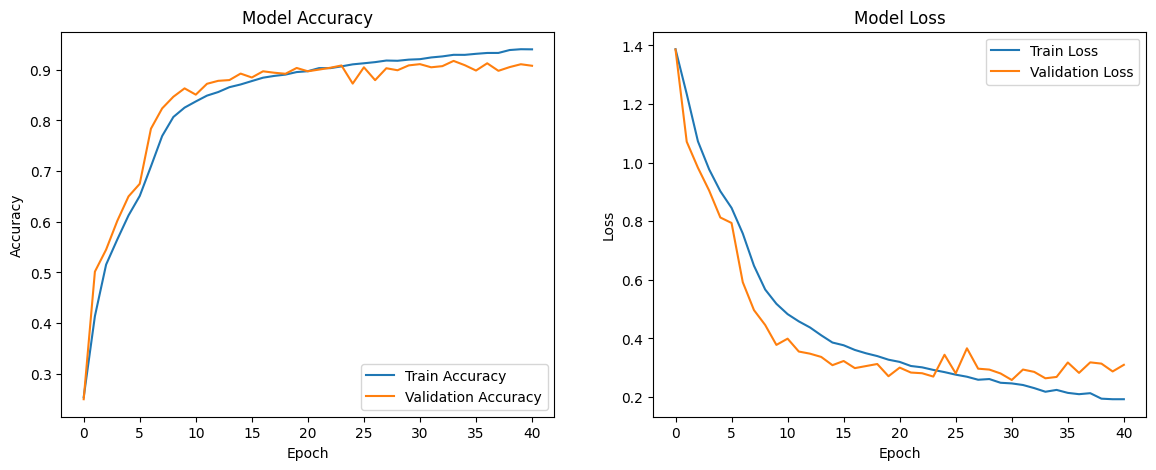

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step


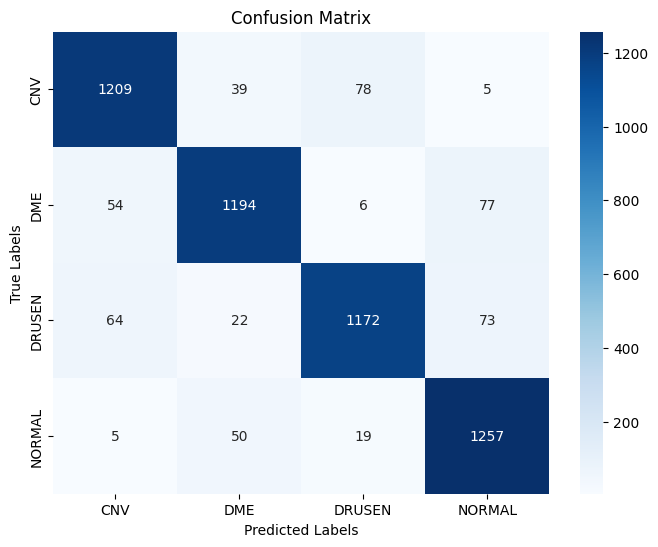

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [25]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))
print(report)


              precision    recall  f1-score   support

         CNV       0.91      0.91      0.91      1331
         DME       0.91      0.90      0.91      1331
      DRUSEN       0.92      0.88      0.90      1331
      NORMAL       0.89      0.94      0.92      1331

    accuracy                           0.91      5324
   macro avg       0.91      0.91      0.91      5324
weighted avg       0.91      0.91      0.91      5324



In [26]:
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
print(f"Train Accuracy: {train_acc:.4f}")

val_loss, val_acc = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")


Train Accuracy: 0.9431
Validation Accuracy: 0.9110


In [27]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9076


In [28]:
model.save("CNN_Model_Scratch_Bounded-Box_Process.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


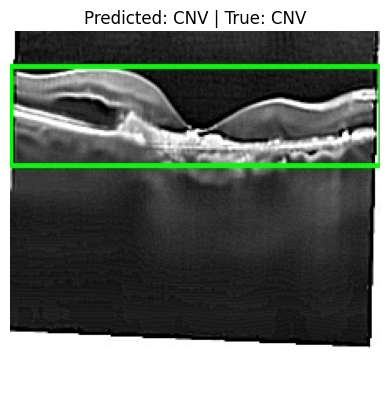

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


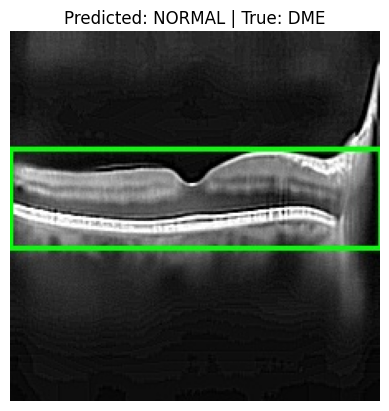

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


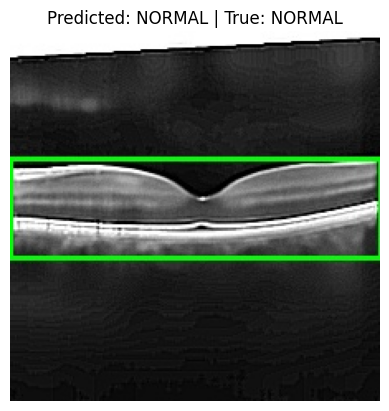

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


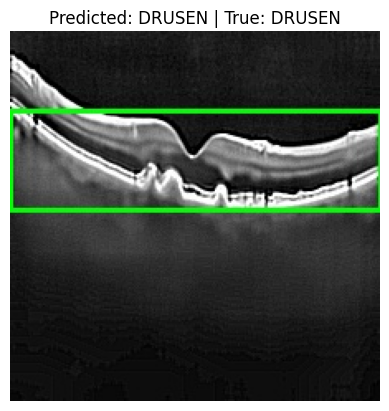

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


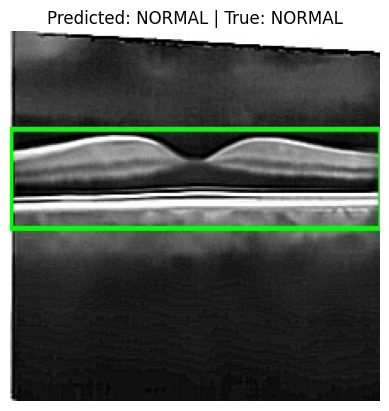

In [30]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path to your test dataset folder
test_folder = '/kaggle/working/split_dataset/test'

# Get class names from subdirectories
class_names = sorted(os.listdir(test_folder))

# Collect all image file paths
image_paths = []
for class_name in class_names:
    class_folder = os.path.join(test_folder, class_name)
    for img_file in os.listdir(class_folder):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append((os.path.join(class_folder, img_file), class_name))

# Choose 5 random images
sample_images = random.sample(image_paths, 5)

# Predict and display
def predict_and_show(img_path, model, class_names, true_label):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0]
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} | True: {true_label}")
    plt.axis('off')
    plt.show()

# Run predictions on the 5 images
for img_path, true_label in sample_images:
    predict_and_show(img_path, model, class_names, true_label)
